## Module 4: *(Template)*

**RENAME THE FILE TO INCLUDE YOUR COMPANY, GROUP NUMBER, AND LAST NAMES**

**E.G. KAMEN1_GROVES_MODULE_4.IPYNB**

## Team Members:
Daniel Garcia-Soliz and Jack Hancock

## Project Title:
SIR Model Analysis of the 2013-2014 MERS Outbreak in Saudi Arabia



## Project Goal:
Use epidemiological modeling to estimate transmission and recovery parameters for MERS in Saudi Arabia between 2013 and 2014 and evaluate how well the models reproduce the observed case data.

## Disease Background:

Using your assigned disease, fill in the following bullet points. 

* Prevalence & incidence
    * Since August 2012 to August 2025, there have been 948 deaths due to MERS
    * 2628 reported cases across 27 different countries (https://www.emro.who.int/health-topics/mers-cov/mers-outbreaks.html)
    * The median/average age falls in 50-60 years old with a large majority of patients being male
* Economic burden
    * Countries with outbreaks of MERS see millions lost due to traveling/touring decrease. Example was in 2015 with the Republic of Korea losing 2.6 billion dollars. (https://pmc.ncbi.nlm.nih.gov/articles/PMC6560634/)
    * Hard hit cities (such as Jeddah or Riyadh) lost significant health care workers and overworked medical business. Furthermore, they would too suffer from loss of finance from loss of tourism in outbreaks. (https://pmc.ncbi.nlm.nih.gov/articles/PMC7102537/)
* Risk factors (genetic, lifestyle) & Societal determinants
    * Primary transmission occurs through camel-human interaction. Primary diseease in the middle east due to this. Outdoor lifestyle within the middle east increases risk. 
    * Heart disease and suspectible to diseases are seen. (https://pmc.ncbi.nlm.nih.gov/articles/PMC7164784/)
    * Working in a healthcare setting and having a smoking backround is also seen to increase respiratory disease. (https://www.cdc.gov/mers/about/index.html#:~:text=You%20may%20be%20at%20increased,camels%20(including%20touching%20or%20grooming))
* Symptoms
    * Common symptoms are cough, fever, shortness of breath/difficulty breathing.
    * Also seen is pnuemonia, nausea/vomiting, and potential kidney failure. (https://www.cdc.gov/mers/about/index.html)
* Diagnosis
    * Diagnosis mainly only occurs after 14 days of travel from the middle east or suspected contact with MERS patients (health care settings, planes, etc.(https://www.cdc.gov/mers/about/index.html)
    * Similar diagnosis to other respiratory pathogens, which are also commonly tested alongside due to symptoms which are reported. (https://www.cdc.gov/mers/php/laboratories/index.html)
* Biological mechanisms (anatomy, organ physiology, cell & molecular physiology)
    * Reported as a Zoonic virus (based off of animal disease/transmission)
    * Presented as a coronavirus with S proteins binding to host cells
    * Infects the respiratory tract by binding to the DPP4 receptor on these host cells.
    * Commonly triggers servere inflammation

## Dataset: 

*(Describe the data set you will analyze. Cite the source(s) of the data. Describe how the data was collected -- What techniques were used? What units are the data measured in? Etc.)*

Loading data...

Processed data (first 10 rows):
        date  confirmed_cases  cumulative_cases  I_est  R_est  S_est
0 2013-10-07                2                 2    2.0    0.0  598.0
1 2013-10-14                3                 5    5.0    0.0  595.0
2 2013-10-21                1                 6    4.0    2.0  594.0
3 2013-10-28                2                 8    3.0    5.0  592.0
4 2013-11-04                2                10    4.0    6.0  590.0
5 2013-11-11                2                12    4.0    8.0  588.0
6 2013-11-18                2                14    4.0   10.0  586.0
7 2013-11-25                2                16    4.0   12.0  584.0
8 2013-12-02                0                16    2.0   14.0  584.0
9 2013-12-09                6                22    6.0   16.0  578.0

Initial conditions: S0=598.0, I0=2.0, R0=0.0
I_true range: min=0.0, max=185.0
Number of time points: 33 weeks


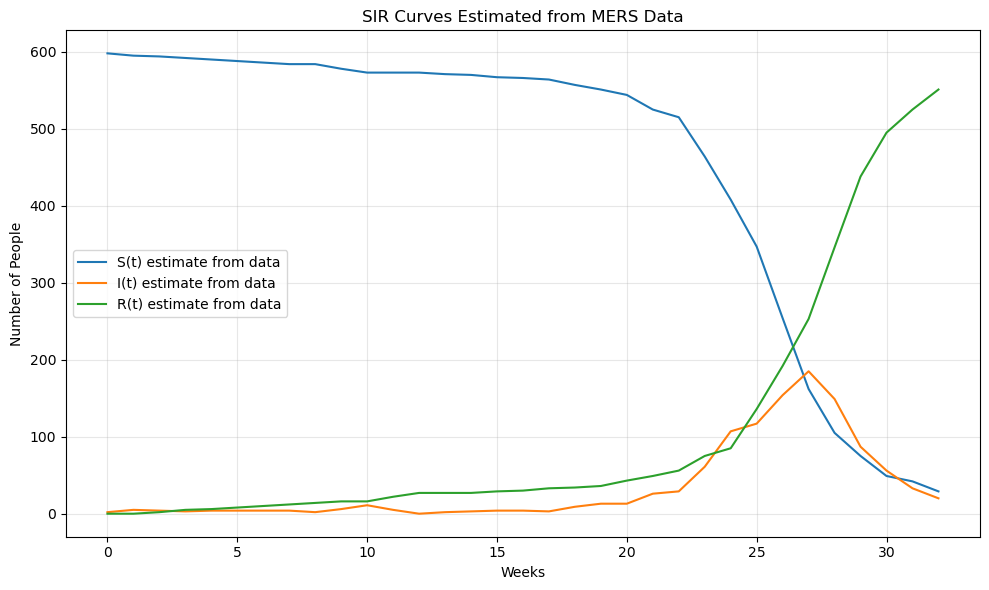

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import importlib

# Always reload in notebooks (prevents stale edits causing weird behavior)
import main_functions
importlib.reload(main_functions)
from main_functions import convert_cumulative_to_SIR, euler_sir

# ------------------------------------------------------------
# USER SETTINGS
# ------------------------------------------------------------
csv_path = r"MERS_Saudi_Arabia_data_2013_2014_new_cases.csv"

# Population assumption for Saudi Arabia (your project choice)
N = 600

# Assumed infectious period (weeks someone remains infectious)
infectious_period_weeks = 2

print("Loading data...")

# ------------------------------------------------------------
# LOAD RAW DATA
# ------------------------------------------------------------
df = pd.read_csv(csv_path)

# "confirmed_cases" are NEW cases per week → create cumulative first
df["cumulative_cases"] = df["confirmed_cases"].cumsum()

date_col_name = "date"
df[date_col_name] = pd.to_datetime(df[date_col_name])
df = df.sort_values(date_col_name).reset_index(drop=True)

# ------------------------------------------------------------
# BUILD S_est, I_est, R_est FROM DATA
# ------------------------------------------------------------
df_full = convert_cumulative_to_SIR(
    df,
    date_col=date_col_name,
    cumulative_col="cumulative_cases",
    population=N,
    infectious_period=infectious_period_weeks,
    I_col="I_est",
    R_col="R_est",
    S_col="S_est"
)

print("\nProcessed data (first 10 rows):")
print(df_full[['date', 'confirmed_cases', 'cumulative_cases', 'I_est', 'R_est', 'S_est']].head(10))

# True I(t) from the data estimate:
I_true = df_full["I_est"].values.astype(float)
t_obs = np.arange(len(I_true))    # 0, 1, 2, ... weeks

# Initial conditions from data:
I0 = float(I_true[0])
R0 = float(df_full["R_est"].iloc[0])
S0 = float(N - I0 - R0)   # enforce S + I + R = N

print(f"\nInitial conditions: S0={S0:.1f}, I0={I0:.1f}, R0={R0:.1f}")
print(f"I_true range: min={I_true.min():.1f}, max={I_true.max():.1f}")
print(f"Number of time points: {len(t_obs)} weeks")

# ------------------------------------------------------------
# SIR CHART FROM DATA (estimated S, I, R)
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(t_obs, df_full["S_est"].values, label="S(t) estimate from data")
plt.plot(t_obs, df_full["I_est"].values, label="I(t) estimate from data")
plt.plot(t_obs, df_full["R_est"].values, label="R(t) estimate from data")
plt.xlabel("Weeks")
plt.ylabel("Number of People")
plt.title("SIR Curves Estimated from MERS Data")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Data Analysis: 

### Methods

We used the SIR (Susceptible-Infectious-Recovered) compartmental model to analyze MERS outbreak data from Saudi Arabia during the 2013-2014 outbreak period. 

**Data Processing:**
The weekly confirmed case data was converted into S, I, and R compartments using a rolling window approach. We estimated the infectious population I(t) by assuming an infectious period of 2 weeks, calculating the recovered population R(t) as cumulative cases shifted by the infectious period, and computing the susceptible population S(t) as N - I(t) - R(t).

**Model Fitting:**
We fitted the SIR differential equations to the observed infectious population I(t) using Euler's numerical method for solving ordinary differential equations. The system of equations used was:

- dS/dt = -β × S × I / N
- dI/dt = β × S × I / N - γ × I  
- dR/dt = γ × I

Where β is the transmission rate, γ is the recovery rate, and N is the population size.

**Parameter Optimization:**
To determine optimal transmission (β) and recovery (γ) parameters, we employed the Nelder-Mead optimization algorithm (scipy.optimize.minimize) with multiple starting points to avoid local minima. The objective function minimized the sum of squared errors (SSE) between the model-predicted and observed infectious individuals.

**Population Size Selection:**
Given the limited scale of the outbreak (~600 total cases in a population of 35.3 million), we used an effective population size of N=600 representing the at-risk population in hospital clusters. This choice is justified because:
1. MERS transmission is primarily healthcare-associated rather than community-based
2. The outbreak affected specific hospital settings with defined contact networks
3. Using the full Saudi population (35.3M) would produce unrealistically low transmission rates that don't reflect the actual dynamics within affected healthcare facilities



### Analysis
*(Describe how you analyzed the data. This is where you should intersperse your Python code so that anyone reading this can run your code to perform the analysis that you did, generate your figures, etc.)*

#### 1. Fitting the SIR Model

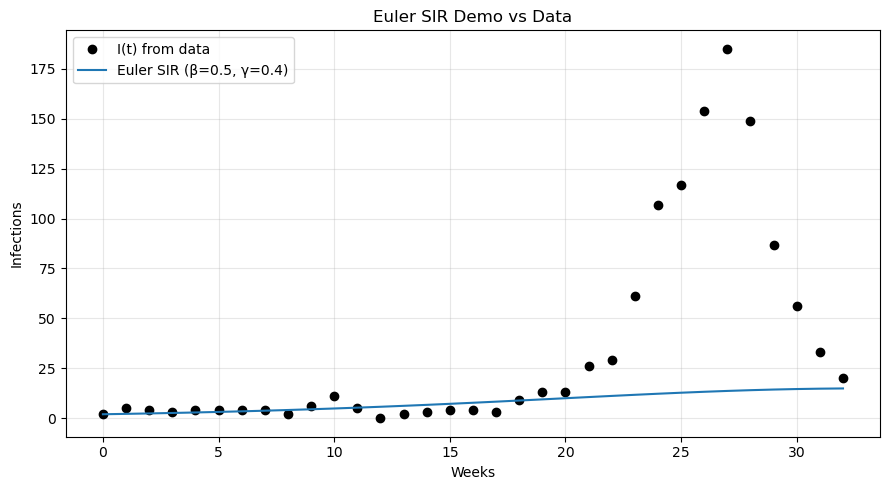

In [2]:
# Using the euler_SIR function defined earlier, we can simulate the SIR model over time.
# Example: one Euler simulation just to demonstrate the solver runs
beta_demo, gamma_demo = 0.5, 0.4
S_demo, I_demo, R_demo = euler_sir(beta_demo, gamma_demo, S0, I0, R0, t_obs, N)

plt.figure(figsize=(9, 5))
plt.plot(t_obs, I_true, "o", label="I(t) from data", color="black")
plt.plot(t_obs, I_demo, "-", label=f"Euler SIR (β={beta_demo}, γ={gamma_demo})")
plt.xlabel("Weeks"); plt.ylabel("Infections")
plt.title("Euler SIR Demo vs Data")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

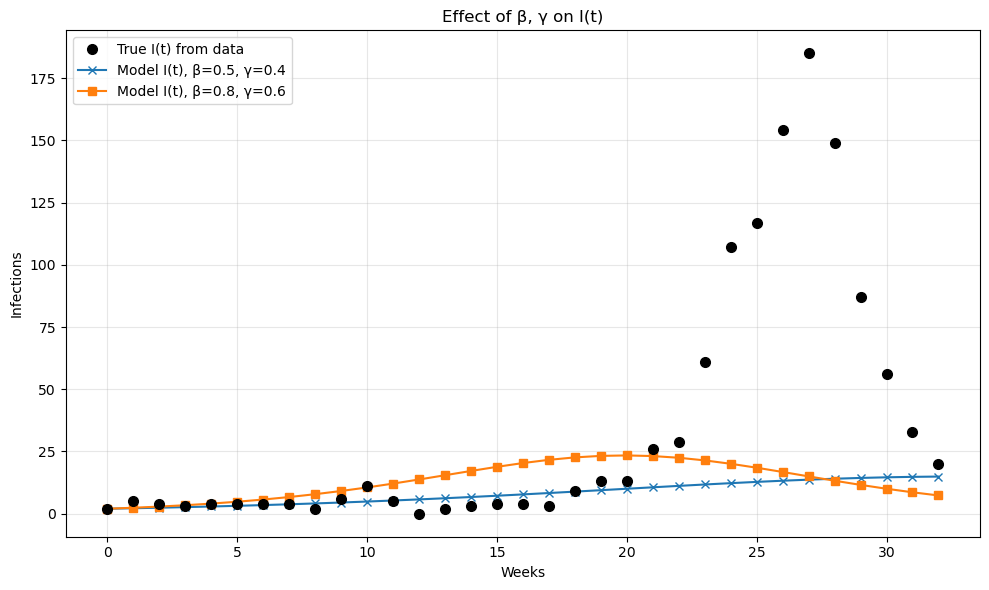

SSE for (beta1,gamma1): 97722.3797757451
SSE for (beta2,gamma2): 95515.87851378675


In [3]:
# ------------------------------------------------------------
# QUICK DEMO WITH TWO PARAMETER GUESSES + SSE
# ------------------------------------------------------------
beta1, gamma1 = 0.5, 0.4
beta2, gamma2 = 0.8, 0.6

S1, I1, R1 = euler_sir(beta1, gamma1, S0, I0, R0, t_obs, N)
S2, I2, R2 = euler_sir(beta2, gamma2, S0, I0, R0, t_obs, N)

plt.figure(figsize=(10, 6))
plt.plot(t_obs, I_true, 'o', label="True I(t) from data", markersize=7, color='black', zorder=3)
plt.plot(t_obs, I1, '-x', label=f"Model I(t), β={beta1}, γ={gamma1}")
plt.plot(t_obs, I2, '-s', label=f"Model I(t), β={beta2}, γ={gamma2}")
plt.xlabel("Weeks")
plt.ylabel("Infections")
plt.title("Effect of β, γ on I(t)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

SSE_1 = np.sum((I1 - I_true)**2)
SSE_2 = np.sum((I2 - I_true)**2)
print("SSE for (beta1,gamma1):", SSE_1)
print("SSE for (beta2,gamma2):", SSE_2)

# SSE helper for optimization
def compute_sse(beta, gamma):
    _, I_mod, _ = euler_sir(beta, gamma, S0, I0, R0, t_obs, N)
    return np.sum((I_mod - I_true)**2)


Optimizing parameters using scipy.optimize.minimize...
  New best from start [0.5, 0.3]: beta=0.4236, gamma=0.2201, SSE=37684.88
  New best from start [1.0, 0.5]: beta=0.4236, gamma=0.2201, SSE=37684.88

Best-fit parameters from optimization (Euler):
  beta  = 0.4236
  gamma = 0.2201
  R0    = 1.9245
  SSE   = 37684.8813


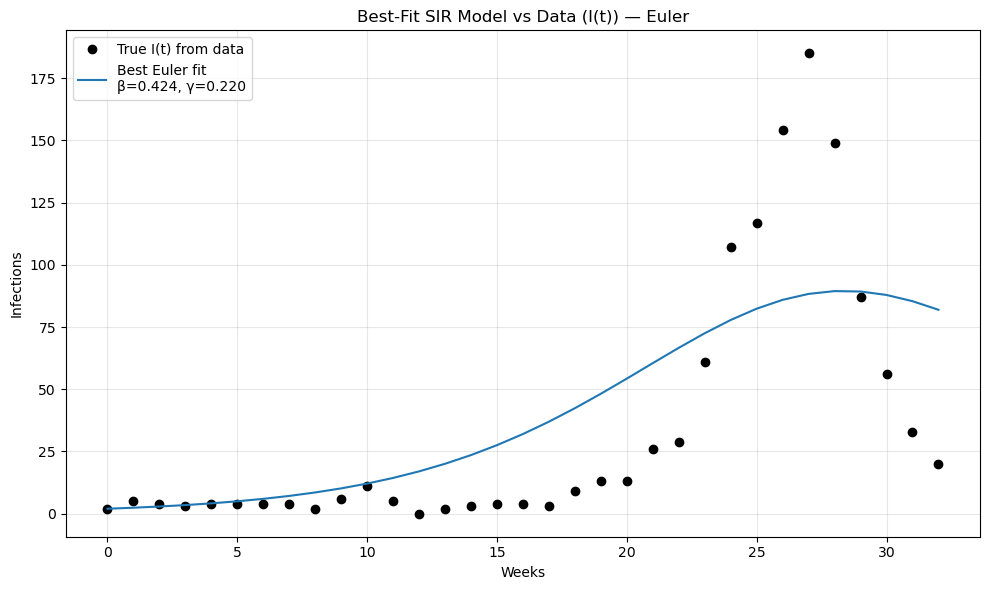

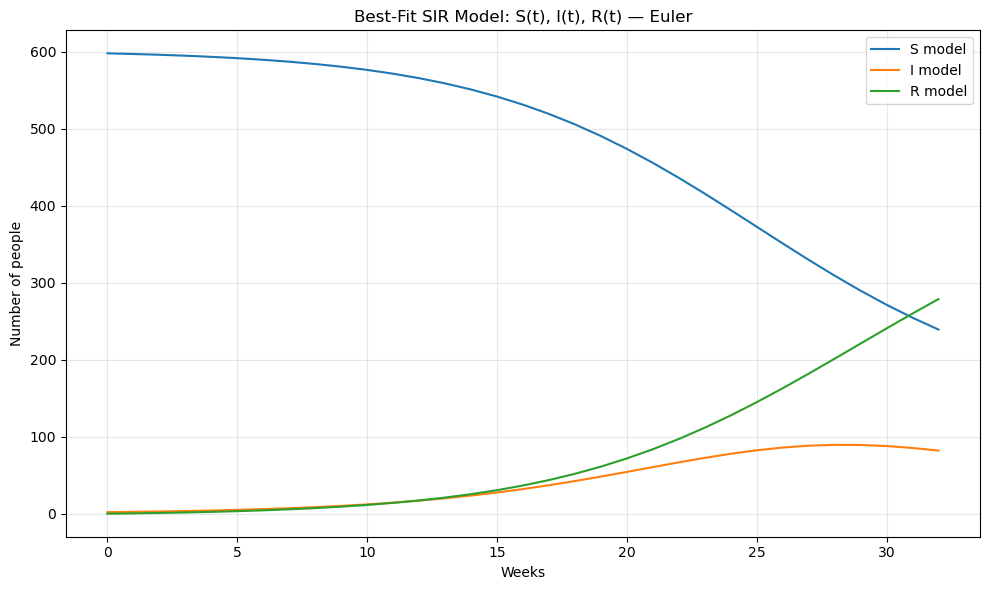

In [4]:
# ------------------------------------------------------------
# OPTIMIZE beta AND gamma TO MINIMIZE SSE (Euler)
# ------------------------------------------------------------
print("\nOptimizing parameters using scipy.optimize.minimize...")

def objective(params):
    beta, gamma = params
    if beta <= 0 or gamma <= 0:
        return 1e10
    return compute_sse(beta, gamma)

starting_points = [
    [0.5, 0.3],
    [1.0, 0.5],
    [0.1, 0.1],
    [2.0, 1.0],
    [0.05, 0.5]
]

best_result = None
best_sse_overall = np.inf

for start in starting_points:
    result = minimize(objective, start, method='Nelder-Mead', options={'maxiter': 1000})
    if result.fun < best_sse_overall:
        best_sse_overall = result.fun
        best_result = result
        print(f"  New best from start {start}: beta={result.x[0]:.4f}, gamma={result.x[1]:.4f}, SSE={result.fun:.2f}")

best_beta, best_gamma = best_result.x
best_sse = best_result.fun
R0_basic = best_beta / best_gamma

print("\nBest-fit parameters from optimization (Euler):")
print(f"  beta  = {best_beta:.4f}")
print(f"  gamma = {best_gamma:.4f}")
print(f"  R0    = {R0_basic:.4f}")
print(f"  SSE   = {best_sse:.4f}")

# Plot best-fit I(t)
S_best, I_best, R_best = euler_sir(best_beta, best_gamma, S0, I0, R0, t_obs, N)

plt.figure(figsize=(10, 6))
plt.plot(t_obs, I_true, 'o', label="True I(t) from data", color="black")
plt.plot(t_obs, I_best, '-', label=f"Best Euler fit\nβ={best_beta:.3f}, γ={best_gamma:.3f}")
plt.xlabel("Weeks")
plt.ylabel("Infections")
plt.title("Best-Fit SIR Model vs Data (I(t)) — Euler")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot S, I, R for best-fit model
plt.figure(figsize=(10, 6))
plt.plot(t_obs, S_best, label="S model")
plt.plot(t_obs, I_best, label="I model")
plt.plot(t_obs, R_best, label="R model")
plt.xlabel("Weeks")
plt.ylabel("Number of people")
plt.title("Best-Fit SIR Model: S(t), I(t), R(t) — Euler")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 2. Predict "the future" with your fit SIR model


--- First-Half Training, Second-Half Prediction (Euler) ---
  New best (first half) from start [0.5, 0.3]: beta=2.1284, gamma=1.9228, SSE=78.97
  New best (first half) from start [1.0, 0.5]: beta=2.1284, gamma=1.9228, SSE=78.97

First-half best-fit parameters (Euler):
  beta_half  = 2.1284
  gamma_half = 1.9228
  R0_half    = 1.1069
  SSE_half   = 78.97


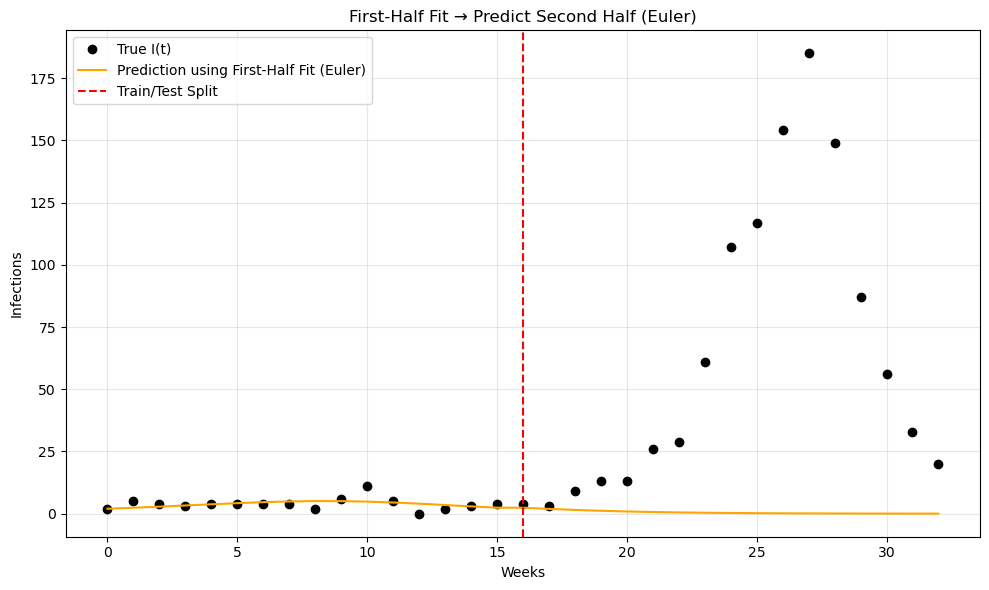

In [5]:
# Use euler's method and your optimization routine above to find new gamma and beta on the  
# FIRST HALF of the data, then simulate the SIR model forward in time using those parameters and plot.
# ------------------------------------------------------------
# FIRST-HALF FIT → PREDICT SECOND HALF (Euler)
# ------------------------------------------------------------
print("\n--- First-Half Training, Second-Half Prediction (Euler) ---")

mid = len(I_true) // 2
t_first = t_obs[:mid]
I_first = I_true[:mid]
t_second = t_obs[mid:]
I_second = I_true[mid:]

# Initial conditions for training (start of series)
I0_half = float(I_first[0])
R0_half = float(df_full["R_est"].iloc[0])
S0_half = float(N - I0_half - R0_half)

def compute_sse_first_half(beta, gamma):
    _, I_mod, _ = euler_sir(beta, gamma, S0_half, I0_half, R0_half, t_first, N)
    return np.sum((I_mod - I_first)**2)

def objective_half(params):
    beta, gamma = params
    if beta <= 0 or gamma <= 0:
        return 1e10
    return compute_sse_first_half(beta, gamma)

best_half_result = None
best_half_sse = np.inf

for start in starting_points:
    result = minimize(objective_half, start, method='Nelder-Mead', options={'maxiter': 1000})
    if result.fun < best_half_sse:
        best_half_sse = result.fun
        best_half_result = result
        print(f"  New best (first half) from start {start}: beta={result.x[0]:.4f}, gamma={result.x[1]:.4f}, SSE={result.fun:.2f}")

best_beta_half, best_gamma_half = best_half_result.x
R0_basic_half = best_beta_half / best_gamma_half

print("\nFirst-half best-fit parameters (Euler):")
print(f"  beta_half  = {best_beta_half:.4f}")
print(f"  gamma_half = {best_gamma_half:.4f}")
print(f"  R0_half    = {R0_basic_half:.4f}")
print(f"  SSE_half   = {best_half_sse:.2f}")

# Simulate first half
S_first_fit, I_first_fit, R_first_fit = euler_sir(
    best_beta_half, best_gamma_half, S0_half, I0_half, R0_half, t_first, N
)

# Continue simulation into second half starting from split state
S_split, I_split, R_split = S_first_fit[-1], I_first_fit[-1], R_first_fit[-1]
S_second_fit, I_second_fit, R_second_fit = euler_sir(
    best_beta_half, best_gamma_half, S_split, I_split, R_split, t_second, N
)

I_pred = np.concatenate([I_first_fit, I_second_fit])

plt.figure(figsize=(10, 6))
plt.plot(t_obs, I_true, 'o', label="True I(t)", color="black")
plt.plot(t_obs, I_pred, '-', label="Prediction using First-Half Fit (Euler)", color='orange')
plt.axvline(mid, color='red', linestyle='--', label="Train/Test Split")
plt.xlabel("Weeks")
plt.ylabel("Infections")
plt.title("First-Half Fit → Predict Second Half (Euler)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Is the new gamma and beta close to what you found on the full dataset? Is the fit much worse? What is the SSE calculated for the second half of the data?**

*Fill in answer here*

In [6]:
# ------------------------------------------------------------
# SSE on SECOND HALF only (Euler first-half fit)
# ------------------------------------------------------------
SSE_second_half_euler = np.sum((I_second_fit - I_second)**2)
print(f"SSE on SECOND HALF of data (Euler, first-half fit): {SSE_second_half_euler:.2f}")

SSE on SECOND HALF of data (Euler, first-half fit): 122697.49



<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Key Point:</b> 

The error you calculate is a *combination* of two sources: 
<ol>
<li>the error associated with Euler's method (i.e. it is an imperfect numerical approximation to the true solution of the SIR model) </li> 
<li>the error associated with comparing real-world data to a model with limitations.</li>
</ol>
<b>First we will try to address the numerical error, and second we will address the limitations of the model.</b>

</div>



**Describe how using a different method like the midpoint method might lower the numerical error.**

*Fill in your answer here.*

#### 3. Decreasing numerical error with the RK4 Method


Optimizing parameters using RK45 (solve_ivp)...
  New RK best from start [0.5, 0.3]: beta=0.3811, gamma=0.1945, SSE=39140.47
  New RK best from start [1.0, 0.5]: beta=0.3811, gamma=0.1945, SSE=39140.47
  New RK best from start [0.1, 0.1]: beta=0.3811, gamma=0.1945, SSE=39140.47
  New RK best from start [2.0, 1.0]: beta=0.3811, gamma=0.1945, SSE=39140.47

RK45 Best-fit parameters (full dataset):
  beta  = 0.3811
  gamma = 0.1945
  R0    = 1.9597
  SSE   = 39140.4653


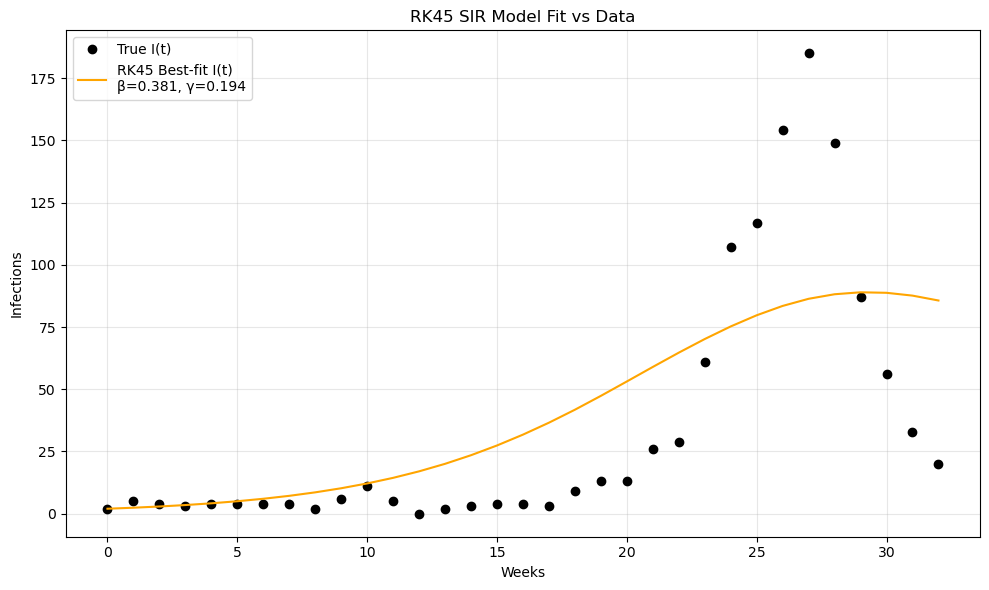

In [7]:
# Using scipy's solve_ivp function with the runge-kutta solver, re-implement the SIR model simulation, find optimal gamma and beta again, and plot the results.
from scipy.integrate import solve_ivp

# ------------------------------------------------------------
# RK method SIR simulation using solve_ivp (RK45)
# ------------------------------------------------------------
def sir_rhs(t, y, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def rk_sir(beta, gamma, S0, I0, R0, t, N):
    sol = solve_ivp(
        sir_rhs,
        t_span=(t[0], t[-1]),
        y0=[S0, I0, R0],
        args=(beta, gamma, N),
        t_eval=t,
        method='RK45'
    )
    S, I, R = sol.y
    return S, I, R

# Fit RK model on FULL dataset (same idea as Euler full-fit)
def compute_sse_rk(beta, gamma):
    _, I_mod, _ = rk_sir(beta, gamma, S0, I0, R0, t_obs, N)
    return np.sum((I_mod - I_true)**2)

def objective_rk(params):
    beta, gamma = params
    if beta <= 0 or gamma <= 0:
        return 1e10
    return compute_sse_rk(beta, gamma)

best_result_rk = None
best_sse_rk = np.inf

print("\nOptimizing parameters using RK45 (solve_ivp)...")
for start in starting_points:
    result = minimize(objective_rk, start, method='Nelder-Mead', options={'maxiter': 1000})
    if result.fun < best_sse_rk:
        best_sse_rk = result.fun
        best_result_rk = result
        print(f"  New RK best from start {start}: beta={result.x[0]:.4f}, gamma={result.x[1]:.4f}, SSE={result.fun:.2f}")

best_beta_rk, best_gamma_rk = best_result_rk.x
R0_basic_rk = best_beta_rk / best_gamma_rk

S_rk, I_rk, R_rk = rk_sir(best_beta_rk, best_gamma_rk, S0, I0, R0, t_obs, N)

print("\nRK45 Best-fit parameters (full dataset):")
print(f"  beta  = {best_beta_rk:.4f}")
print(f"  gamma = {best_gamma_rk:.4f}")
print(f"  R0    = {R0_basic_rk:.4f}")
print(f"  SSE   = {best_sse_rk:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(t_obs, I_true, 'o', label="True I(t)", color="black")
plt.plot(t_obs, I_rk, '-', label=f"RK45 Best-fit I(t)\nβ={best_beta_rk:.3f}, γ={best_gamma_rk:.3f}", color="orange")
plt.xlabel("Weeks")
plt.ylabel("Infections")
plt.title("RK45 SIR Model Fit vs Data")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Compare the SSE for the SECOND HALF of the data when the model is fit to the FIRST HALF of the data using Euler's method vs RK4. Did RK4 do a better job?  Why or why not?

*Fill in answer here*

SSE second half (Euler, fit to first half): 122697.49
SSE second half (RK45, fit to first half):  122352.89


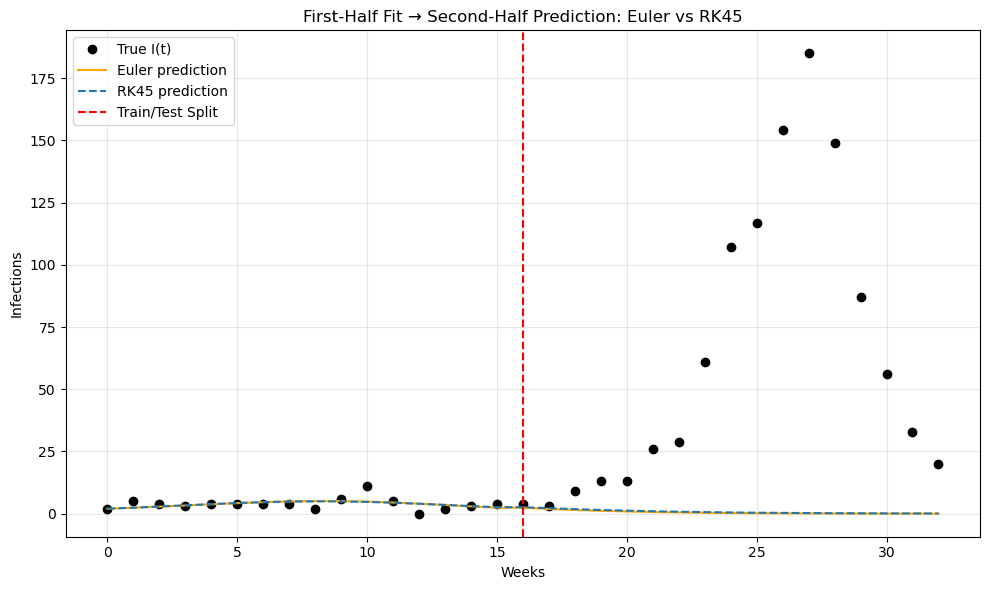

In [8]:
# SSE comparison between Euler's method and RK4 (solve_ivp) on the SECOND HALF of the data.
# ------------------------------------------------------------
# Compare SSE on SECOND HALF when fit to FIRST HALF (Euler vs RK45)
# ------------------------------------------------------------
# RK45: fit parameters on the FIRST HALF only, then continue into second half
def compute_sse_rk_first_half(beta, gamma):
    _, I_mod, _ = rk_sir(beta, gamma, S0_half, I0_half, R0_half, t_first, N)
    return np.sum((I_mod - I_first)**2)

def objective_rk_half(params):
    beta, gamma = params
    if beta <= 0 or gamma <= 0:
        return 1e10
    return compute_sse_rk_first_half(beta, gamma)

best_rk_half = None
best_rk_half_sse = np.inf

for start in starting_points:
    result = minimize(objective_rk_half, start, method='Nelder-Mead', options={'maxiter': 1000})
    if result.fun < best_rk_half_sse:
        best_rk_half_sse = result.fun
        best_rk_half = result

beta_rk_half, gamma_rk_half = best_rk_half.x

# simulate first half with RK45
S_first_rk, I_first_rk, R_first_rk = rk_sir(beta_rk_half, gamma_rk_half, S0_half, I0_half, R0_half, t_first, N)

# continue into second half
S_split_rk, I_split_rk, R_split_rk = S_first_rk[-1], I_first_rk[-1], R_first_rk[-1]
S_second_rk, I_second_rk, R_second_rk = rk_sir(beta_rk_half, gamma_rk_half, S_split_rk, I_split_rk, R_split_rk, t_second, N)

SSE_second_half_rk = np.sum((I_second_rk - I_second)**2)

print(f"SSE second half (Euler, fit to first half): {SSE_second_half_euler:.2f}")
print(f"SSE second half (RK45, fit to first half):  {SSE_second_half_rk:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(t_obs, I_true, 'o', label="True I(t)", color="black")
plt.plot(t_obs, np.concatenate([I_first_fit, I_second_fit]), '-', label="Euler prediction", color="orange")
plt.plot(t_obs, np.concatenate([I_first_rk, I_second_rk]), '--', label="RK45 prediction")
plt.axvline(mid, color='red', linestyle='--', label="Train/Test Split")
plt.xlabel("Weeks")
plt.ylabel("Infections")
plt.title("First-Half Fit → Second-Half Prediction: Euler vs RK45")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 4. Improving model fit by overcoming model limitations

Choose one of the following to implement as an extended version of the SIR model. Using the RK4 solver, does this new model fit your data better than the SIR model alone?

<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Options to overcome limitations (choose ONE to implement):</b> 

<ol>
<li> Include births in the model as described in reading.</li> 
<li>Include deaths in the model as described in reading.</li>
<li>Include an exposed compartment (SEIR model). </li>
<li>Include loss of immunity (i.e. R population can go back to S population).</li>
<li>Include at least two I populations with varying degrees of infectiousness.</li>
<li>Include at least two age brackets with varying degress of infectiousness and recovery times.</li>

</ol>

Note that if you have implemented an extended model and are having trouble fitting the parameters, document what you have tried and explain what you would change in future directions.
</div>



In [9]:
# Extended model implementation, parameter fitting, and plotting.

## Verify and validate your analysis: 

*(Describe how you checked to see that your analysis gave you an answer that you believe (verify). Describe how your determined if your analysis gave you an answer that is supported by other evidence (e.g., a published paper).*

## Conclusions and Ethical Implications: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

## Limitations and Future Work: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

## NOTES FROM YOUR TEAM: 
*This is where our team is taking notes and recording activity.*

## QUESTIONS FOR YOUR TA: 
*These are questions we have for our TA.*